<a href="https://colab.research.google.com/github/arumshin-dev/python_conda_jupyter/blob/main/codeit/1.MNIST_samplecode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 라이브러리

In [17]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# PyTorch, NumPy, scikit-learn 같은 라이브러리들은 내부적으로 OpenMP를 사용해서 CPU 병렬 연산 가속화
# 그런데 여러 라이브러리가 각각 자기 버전의 OpenMP 런타임(libomp)을 로딩하면 충돌이 발생
# 임시 - OpenMP(Open Multi-Processing)라는 병렬 처리 라이브러리의 충돌을 무시하고 실행을 계속하라는 설정
# 새로운 Conda 환경에서 필요 라이브러리만 설치하고 OpenMP 충돌 없이 실행하는게 좋다.
import torch # 파이토치PyTorch 메인 라이브러리
import torch.nn as nn # 신경망(neural network) 관련 기능-신경망 구성요소들(레이어, 손실함수 등)
import torch.optim as opt # 최적화(optimization) 관련 기능-모델 학습에 사용되는 알고리즘들(SGD, Adam 등)
from torchvision import datasets, transforms # 이미지 데이터셋과 변환 기능 제공 -전처리 도구들

# 1 환경설정

In [2]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # GPU 사용 가능하면 GPU, 아니면 CPU
print(device) # 현재 사용중인 device 출력

cpu


# 2 MNIST 데이터셋 로드

In [3]:
# MNIST 데이터셋 로드 - 훈련용 60,000개, 테스트용 10,000개 이미지 다운로드
# 이미지를 텐서(tensor)로 변환하는 전처리(transform) 적용- 픽셀값을 0~1 사이로 변환(정규화)
train_dataset = datasets.MNIST(root='./data',# 데이터셋 저장 위치
                               train=True,# 훈련용 데이터셋 사용
                               transform=transforms.ToTensor(),# 이미지 -> 텐서 변환(0~1 사이 값으로 정규화)
                               download=True)# 데이터셋이 없으면 다운로드
test_dataset = datasets.MNIST(root='data',
                              train=False,# 테스트용 데이터셋 사용
                              transform=transforms.ToTensor(),
                              download=True)

In [4]:
# 데이터셋 정보 출력
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


# 3 데이터 로더 생성

In [5]:
# 데이터 로더
# 데이터를 미니배치 단위로 불러오는 도구
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True)# 훈련용 데이터는 셔플(무작위 섞기) 적용
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=64,
                                          shuffle=False)# 테스트용 데이터는 셔플 적용 안함

torch.Size([4, 1, 28, 28])
torch.Size([4])
tensor([1, 7, 2, 4])
torch.Size([28, 28])
tensor(1)


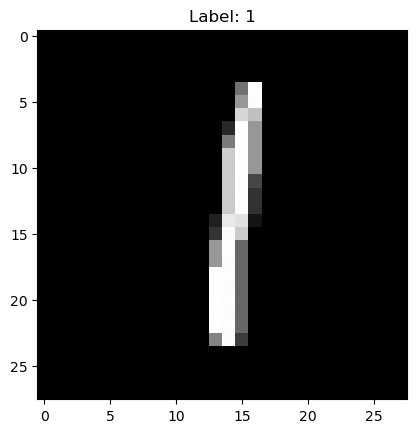

In [6]:
# 데이터 확인
# 미니배치 단위로 데이터 불러오기

images, labels = next(iter(train_loader))
print(images.shape)# b,c,h,w # images: (배치크기, 채널수, 높이, 너비) # 흑백이미지(채널수=1), 컬러이미지(채널수=3) # 높이, 너비=28x28
print(labels.shape)# labels: (배치크기) # 레이블: 0~9 사이의 정수(숫자 이미지의 실제 값)
print(labels) # 레이블: 0~9 사이의 정수(숫자 이미지의 실제 값)

# 이미지 데이터 시각화
import matplotlib.pyplot as plt
# 첫번째 이미지와 레이블 출력
img = images[0].squeeze() # (1,28,28) -> (28,28) # squeeze(): 차원 축소
print(img.shape)# (28,28)

label = labels[0]# 첫번째 이미지의 레이블
print(label)# 레이블 출력

# 이미지 출력
plt.imshow(img, cmap='gray')# 흑백 이미지 출력
plt.title(f'Label: {label}')# 이미지 제목에 레이블 표시
plt.show()

In [7]:
import matplotlib.pyplot as plt
img = images[0].squeeze()
print(img.shape)

torch.Size([28, 28])


torch.Size([4, 1, 28, 28])
torch.Size([4])


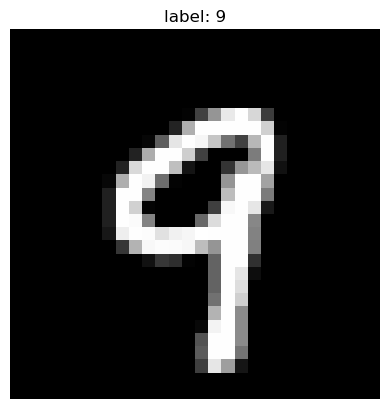

torch.Size([1, 28, 28])
torch.Size([28, 1, 28])


In [8]:
images, labels = next(iter(train_loader))

print(images.shape) # b,c,h,w
print(labels.shape)

import matplotlib.pyplot as plt

img = images[0].squeeze()
label = labels[0]

plt.imshow(img,cmap='gray')
plt.title(f'label: {label.item()}')
plt.axis('off')
plt.show()

print(img.unsqueeze(0).shape)
print(img.unsqueeze(1).shape)

# 5 MLP(다층 퍼셉트론) 신경망

In [9]:
# MLP 모델 정의
class MLP(nn.Module): # nn.Module 상속받아 MLP 클래스 정의
    #input_size 입력층,
    # 은닉층1
    # 은닉층2
    # 3개층으로 구성
    def __init__(self, input_size, hidden_size, num_cls):
        super(MLP, self).__init__()# 부모 클래스(nn.Module) 초기화
        # 각 레이어 층(layer) 정의
        self.linear1 = nn.Linear(input_size, hidden_size)# 입력층 -> 은닉층1
        self.relu = nn.ReLU()# 활성화 함수 ReLU (음수를 0으로 변환, 양수는 그대로)
        self.linear2 = nn.Linear(hidden_size, hidden_size)# 은닉층1 -> 은닉층2
        self.relu2 = nn.ReLU()# 활성화 함수 ReLU

        self.output = nn.Linear(hidden_size, num_cls)# 은닉층2 -> 출력층

    #데이터가 모델에 들어왔을 때의 앞으로 흘러가는 과정 (순전파)
    def forward(self, x):# 순전파(forward) 함수 정의 # 모델에 입력 데이터가 들어왔을 때의 연산 과정
        x = self.linear1(x)# 입력층 -> 은닉층1 :첫번째 선형 변환
        x = self.relu(x)# ReLU 적용 - 비선형성 추가
        x = self.linear2(x)# 은닉층1 -> 은닉층2 : 두번째 선형 변환
        x = self.relu2(x)# ReLU 적용 - 비선형성 추가
        out = self.output(x)# 은닉층2 -> 출력층 : 세번째 선형 변환- 최종 출력

        return out

# 6 MLP 모델 학습

In [10]:
# 모델 파라미터 설정
input_size = 784 #28*28 픽셀을 1차원 벡터로 변환(일렬로 펼친 크기)
hidden_size = 500 # 은닉층 크기? 은닉층 뉴런 개수
num_cls = 10 # 숫자 0~9 -> 10개의 클래스 ? 분류할 클래스 개수
epochs = 3 # 전체 데이터셋을 몇 번 반복해서 학습할지

# 모델 생성 및 cpu(gpu)로 이동
model = MLP(input_size, hidden_size, num_cls).to(device)

# 손실함수와 최적화 알고리즘(옵티마이저) 정의
loss_fn = nn.CrossEntropyLoss()# 다중 클래스 분류에 자주 사용되는 손실함수
# 옵티마이저(optimizer): 모델의 파라미터(가중치)를 학습 데이터에 맞게 업데이트하는 역할
# 손실함수(loss function)를 최소화하는 방향으로 파라미터를 조정함
# 대표적인 옵티마이저: SGD, Adam, RMSprop 등
optimizer = opt.Adam(model.parameters(), lr=0.001)# Adam: 대표적인 최적화 알고리즘, 학습 속도와 성능이 좋음, 학습률: 0.001

# 학습 시작
for epoch in range(epochs): # epoch 반복
    for i, (images, labels) in enumerate(train_loader):# 미니배치 단위로 데이터 불러오기 반복
        # 데이터 전처리 및 디바이스 이동
        images = images.reshape(-1, input_size).to(device) # (b,1,28,28) -> (b,784) # 1차원 벡터로 변환
        labels = labels.to(device)

        # 모델을 실행 => 순전파
        outputs = model(images)# 모델에 이미지 입력 -> 예측 출력
        loss = loss_fn(outputs, labels)# 예측 출력과 실제 레이블 간의 손실 계산

        # 역전파 & 옵티마이저 -역전파 및 가중치 업데이트
        optimizer.zero_grad() # 이전 기울기를 초기화
        loss.backward() # 역전파(Backpropagation)로 기울기 계산
        optimizer.step()# 웨이트를 업데이트

#        print(f"Epoch {epoch}, loss: {loss}")
        if(i+1)%100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        # Forward

Epoch [1/3], Step [100/15000], Loss: 0.3263
Epoch [1/3], Step [200/15000], Loss: 0.5777
Epoch [1/3], Step [300/15000], Loss: 0.1990
Epoch [1/3], Step [400/15000], Loss: 0.2967
Epoch [1/3], Step [500/15000], Loss: 1.3339
Epoch [1/3], Step [600/15000], Loss: 1.2249
Epoch [1/3], Step [700/15000], Loss: 0.0247
Epoch [1/3], Step [800/15000], Loss: 0.1776
Epoch [1/3], Step [900/15000], Loss: 0.5947
Epoch [1/3], Step [1000/15000], Loss: 0.3173
Epoch [1/3], Step [1100/15000], Loss: 0.6589
Epoch [1/3], Step [1200/15000], Loss: 0.0435
Epoch [1/3], Step [1300/15000], Loss: 1.8263
Epoch [1/3], Step [1400/15000], Loss: 0.0230
Epoch [1/3], Step [1500/15000], Loss: 0.3989
Epoch [1/3], Step [1600/15000], Loss: 0.1645
Epoch [1/3], Step [1700/15000], Loss: 0.3482
Epoch [1/3], Step [1800/15000], Loss: 0.0072
Epoch [1/3], Step [1900/15000], Loss: 0.0247
Epoch [1/3], Step [2000/15000], Loss: 0.0059
Epoch [1/3], Step [2100/15000], Loss: 0.4192
Epoch [1/3], Step [2200/15000], Loss: 0.0021
Epoch [1/3], Step [

In [11]:
print(model)

MLP(
  (linear1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=500, out_features=500, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=500, out_features=10, bias=True)
)


# 7 MLP 모델 테스트

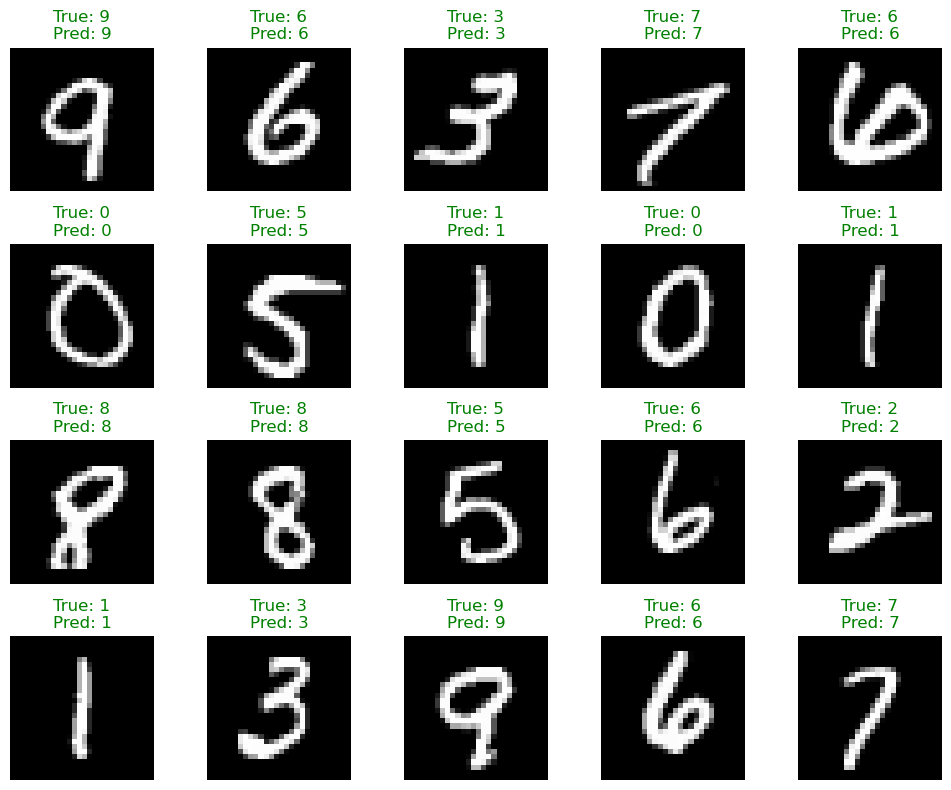

In [12]:
# prompt: 테스트 셋에서 20개정도 샘플을 추출해서 결과를 표시해

import matplotlib.pyplot as plt
import numpy as np

# 테스트 셋에서 20개 샘플 추출
sample_indices = np.random.choice(len(test_dataset), 20, replace=False)
sampled_images = [test_dataset[i][0] for i in sample_indices]
sampled_labels = [test_dataset[i][1] for i in sample_indices]

# 모델 예측
model.eval()  # 평가 모드로 설정
predicted_labels = []
with torch.no_grad():
  for image in sampled_images:
    image = image.reshape(-1, input_size).to(device)
    image = image.to(device)
    output = model(image).argmax()
    predicted_labels.append(output.item())

# 결과 시각화
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
  ax.imshow(sampled_images[i].squeeze().numpy(), cmap='gray')
  ax.set_title(f'True: {sampled_labels[i]}\nPred: {predicted_labels[i]}',
               color='green' if sampled_labels[i] == predicted_labels[i] else 'red')
  ax.axis('off')
plt.tight_layout()
plt.show()

# 8 CNN(합성곱 신경망) 모델 정의

In [13]:
class CNN(nn.Module):
    def __init__(self, input_ch, hidden_size, num_cls):
        super(CNN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(input_ch, hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)

        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(hidden_size, input_ch, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()
        # self.output = nn.Linear(hidden_size, num_cls)
        self.output = nn.Linear(784, num_cls)# 퍼셉트론

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.flatten(x)
        out = self.output(x)

        return out


In [18]:
# input_size = 784 #28*28
# hidden_size = 500
# num_cls = 10
epochs = 3
#input_ch, hidden_size, num_cls
model_cnn = CNN(1, 16, 10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = opt.Adam(model_cnn.parameters(), lr=0.001)

# 학습
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 데이터를 디바이스로 이동
        # images = images.reshape(-1, input_size).to(device)
        images = images.to(device)
        labels = labels.to(device)

        # 모델을 셀행
        outputs = model_cnn(images).squeeze()
        loss = loss_fn(outputs, labels)

        # 역전파 & 옵티마이저
        optimizer.zero_grad()# 기울기가 있었으면 기울기를 초기화 시켜줌
        loss.backward()# 뒤로 백 프로파게이션 할 준비
        optimizer.step()# 웨이트를 업데이트

        if(i+1)%100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

Epoch [1/3], Step [100/15000], Loss: 0.2391
Epoch [1/3], Step [200/15000], Loss: 0.2420
Epoch [1/3], Step [300/15000], Loss: 1.4818
Epoch [1/3], Step [400/15000], Loss: 0.2213
Epoch [1/3], Step [500/15000], Loss: 0.3670
Epoch [1/3], Step [600/15000], Loss: 0.2934
Epoch [1/3], Step [700/15000], Loss: 1.0345
Epoch [1/3], Step [800/15000], Loss: 0.5779
Epoch [1/3], Step [900/15000], Loss: 0.2537
Epoch [1/3], Step [1000/15000], Loss: 0.0275
Epoch [1/3], Step [1100/15000], Loss: 0.5041
Epoch [1/3], Step [1200/15000], Loss: 0.5970
Epoch [1/3], Step [1300/15000], Loss: 0.1589
Epoch [1/3], Step [1400/15000], Loss: 0.1924
Epoch [1/3], Step [1500/15000], Loss: 1.1042
Epoch [1/3], Step [1600/15000], Loss: 0.1573
Epoch [1/3], Step [1700/15000], Loss: 0.1063
Epoch [1/3], Step [1800/15000], Loss: 1.5070
Epoch [1/3], Step [1900/15000], Loss: 0.1108
Epoch [1/3], Step [2000/15000], Loss: 1.3004
Epoch [1/3], Step [2100/15000], Loss: 0.0161
Epoch [1/3], Step [2200/15000], Loss: 0.0820
Epoch [1/3], Step [

In [15]:
print(model_cnn)

CNN(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (block3): Sequential(
    (0): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (output): Linear(in_features=784, out_features=10, bias=True)
)


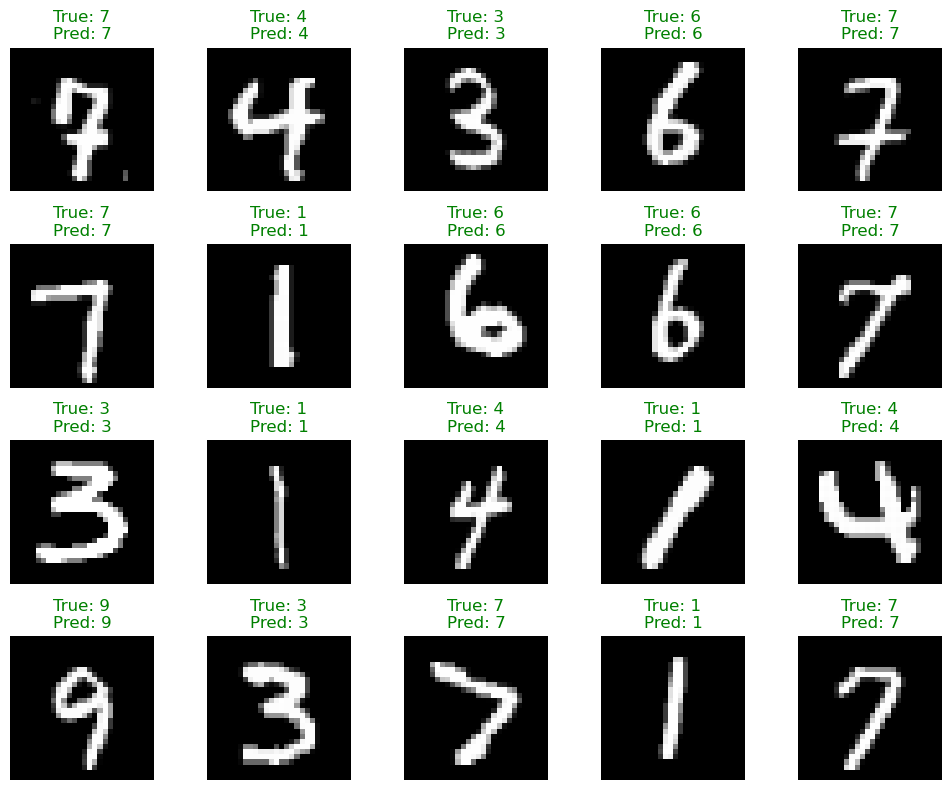

In [22]:
# prompt: 테스트 셋에서 20개정도 샘플을 추출해서 결과를 표시해

import matplotlib.pyplot as plt
import numpy as np

# 테스트 셋에서 20개 샘플 추출
sample_indices = np.random.choice(len(test_dataset), 20, replace=False)
sampled_images = [test_dataset[i][0] for i in sample_indices]
sampled_labels = [test_dataset[i][1] for i in sample_indices]

# 모델 예측
model_cnn.eval()  # 평가 모드로 설정
predicted_labels = []
with torch.no_grad():
  for image in sampled_images:
    # image = image.reshape(-1, input_size).to(device)
    image = image.to(device)
    output = model_cnn(image).argmax()
    predicted_labels.append(output.item())

# 결과 시각화
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
  ax.imshow(sampled_images[i].squeeze().numpy(), cmap='gray')
  ax.set_title(f'True: {sampled_labels[i]}\nPred: {predicted_labels[i]}',
               color='green' if sampled_labels[i] == predicted_labels[i] else 'red')
  ax.axis('off')
plt.tight_layout()
plt.show()